# Predicting Match Outcomes

In [1]:
#SQL Imports
import mysql.connector
#Pandas imports
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt


In [2]:
mydb = mysql.connector.connect(
  host="localhost",
  user="root",
  passwd="NYg1@nts",
  database="NRL_data"
)
mycursor = mydb.cursor()

## Create match_stat_df of aggregated player stats for each match

In [3]:
query = pd.read_sql_query('''
    SELECT * 
    FROM PlayerMatchStats
''', mydb)
player_stat_df = pd.DataFrame(query)
match_stat_df = player_stat_df.groupby(['match_id','team_id']).sum().reset_index()
match_stat_df = match_stat_df.drop(columns=['id', 'player_id', 'position_id', 'minutes_played'])
#match_stat_df.columns
#print(match_stat_df.dtypes)

In [4]:
def get_averages(df):
    df['metres_per_kick'] = df['kicking_metres'] / df['kicks']
    df['metres_per_run'] = df['total_run_metres'] / df['total_runs']
    df['metres_ran_per_try'] = df['total_run_metres'] / df['tries']
    df['tackle_percentage'] = df['tackles_made'] / (df['tackles_made'] + df['tackles_missed'] + df['ineffective_tackles'])
    return df
match_stat_df = get_averages(match_stat_df)
match_stat_df = match_stat_df.drop(columns=['average_play_ball_seconds']).fillna(0)
match_stat_df.head()

,match_id,team_id,points,tries,conversions,conversion_attempts,penalty_goals,field_goals,total_runs,total_run_metres,...,handling_errors,one_on_ones_lost,penalties,on_report,sin_bins,send_offs,metres_per_kick,metres_per_run,metres_ran_per_try,tackle_percentage
0,1,1,12,2,1,2,1,0,130,1076,...,11,0,9,1,0,0,27.285714,8.276923,538.000000,0.871465
1,1,14,34,5,4,5,3,0,168,1618,...,9,2,7,0,0,0,28.117647,9.630952,323.600000,0.888060
2,2,6,18,3,2,3,1,0,178,1648,...,10,0,11,0,0,0,21.846154,9.258427,549.333333,0.888350
3,2,8,19,3,3,3,0,1,192,1425,...,6,0,9,0,0,0,25.619048,7.421875,475.000000,0.846535
4,3,4,14,2,2,2,1,0,134,1144,...,12,0,10,0,0,0,20.928571,8.537313,572.000000,0.865952


## Create match_df of info not related to player stats

In [5]:
match_query = pd.read_sql_query('''
    SELECT id, date, round, home_team_id, home_score, away_team_id, away_score, winner, home_odds, away_odds, draw_odds
    FROM Matches
''', mydb)
match_df = pd.DataFrame(match_query).rename(columns={'id': 'match_id'})
match_df['date'] = pd.to_datetime(match_df['date'])
match_df.head()

,match_id,date,round,home_team_id,home_score,away_team_id,away_score,winner,home_odds,away_odds,draw_odds
0,1,2018-03-08,1.0,14,34,1,12,14,0.5882,0.4386,0.0488
1,2,2018-03-09,1.0,8,19,6,18,8,0.5181,0.5128,0.0501
2,3,2018-03-09,1.0,10,20,4,14,10,0.5988,0.4329,0.0482
3,4,2018-03-10,1.0,16,10,15,8,15,0.25,0.7874,0.0369
4,5,2018-03-10,1.0,13,20,9,32,9,0.6803,0.3509,0.0476


In [6]:
#Add date to match_stat_df
match_stat_df = pd.merge(match_stat_df, match_df[['match_id', 'date', 'winner']], on='match_id', how='inner')
match_stat_df['is_winner'] = match_stat_df.apply(lambda x: 1 if x['team_id'] == x['winner'] else 0, axis=1)
match_stat_df = match_stat_df.drop(columns='winner')
match_stat_df.head()

,match_id,team_id,points,tries,conversions,conversion_attempts,penalty_goals,field_goals,total_runs,total_run_metres,...,penalties,on_report,sin_bins,send_offs,metres_per_kick,metres_per_run,metres_ran_per_try,tackle_percentage,date,is_winner
0,1,1,12,2,1,2,1,0,130,1076,...,9,1,0,0,27.285714,8.276923,538.000000,0.871465,2018-03-08,0
1,1,14,34,5,4,5,3,0,168,1618,...,7,0,0,0,28.117647,9.630952,323.600000,0.888060,2018-03-08,1
2,2,6,18,3,2,3,1,0,178,1648,...,11,0,0,0,21.846154,9.258427,549.333333,0.888350,2018-03-09,0
3,2,8,19,3,3,3,0,1,192,1425,...,9,0,0,0,25.619048,7.421875,475.000000,0.846535,2018-03-09,1
4,3,4,14,2,2,2,1,0,134,1144,...,10,0,0,0,20.928571,8.537313,572.000000,0.865952,2018-03-09,0


# Create class for each team

In [8]:
class Teams:
    all_teams = {}
    
    def __init__(self, name, id):
        self.name = name
        self.id = id
        self.match_stats = match_stat_df[match_stat_df['team_id'] == self.id]
        self.opposition_stats = self.get_opposition_stats()
        Teams.all_teams[self.name] = self
    
    def get_roster(self):
        roster_df = player_stat_df[player_stat_df['team_id'] == self.id]
        roster_df = pd.merge(roster_df, match_df[['match_id', 'date']], on='match_id', how='inner')
        for match in list(roster_df['match_id'].unique()):
            #print(roster_df.head())
            df = roster_df[roster_df['match_id'] == match]
            df = list(df['player_id'])
            #print(df)
    
    def get_opposition_stats(self):
        match_ids = list(self.match_stats['match_id'])
        opposition_df = match_stat_df[(match_stat_df['match_id'].isin(match_ids)) & (match_stat_df['team_id'] != self.id)]
        return opposition_df
    
    def get_stats_most_recent_matches(self, date, x=1):
        date_df = self.match_stats[self.match_stats['date'] < date].sort_values('date', ascending=False)
        date_df = date_df.drop(columns=['date'])
        averages_df = date_df.head(x).sum() / x
        return averages_df
    
    def get_opposition_stats_most_recent_matches(self, date, x=1):
        date_df = self.opposition_stats[self.opposition_stats['date'] < date].sort_values('date', ascending=False)
        date_df = date_df.drop(columns=['date'])
        averages_df = date_df.head(x).sum() / x
        return averages_df
    
    def get_season_averages(self, year, self_or_opposition = 'self'):
        if self_or_opposition == 'opposition':
            stats = self.opposition_stats
        else:
            stats = self.match_stats
        date_df = stats[stats['date'].dt.year == year]
        date_df.drop(columns=['date'])
        averages_df = date_df.sum() / date_df.shape[0]
        return averages_df

team_names_and_ids = pd.DataFrame(pd.read_sql_query('SELECT id, nickname FROM Teams', mydb)).set_index('nickname').to_dict()['id']
for name in team_names_and_ids.keys():
     Teams(name, team_names_and_ids[name])
#print(Teams.all_teams['Roosters'].opposition_stats.head())
#print(Teams.all_teams['Roosters'].get_season_averages(2014))

In [9]:
Teams.all_teams['Roosters'].get_roster()

# Create class for each match

In [10]:
class Matches:
    all_matches = {}
    
    def __init__(self, match_id, round, date, home_team, away_team, winner=None, home_odds=None, away_odds=None):
        self.id = match_id
        self.round = round
        self.date = date
        self.season = self.date.year
        self.home = home_team
        self.home_odds = home_odds
        self.away = away_team
        self.away_odds = away_odds
        if home_team.id == winner:
            self.winner = home_team
            self.home_winner = True
        else:
            self.winner = away_team
            self.home_winner = False
        self.stats = self.get_match_stats()
        self.identifier = str(self.date.date()) + '_' + str(self.id) + '_' + self.home.name + '-v-' + self.away.name
        Matches.all_matches[self.identifier] = self
        #Matches.all_matches.append(self)
    
    def get_match_stats(self):
        match_stats = pd.DataFrame()
        home_stats = self.home.match_stats[self.home.match_stats['match_id'] == self.id]
        away_stats = self.away.match_stats[self.away.match_stats['match_id'] == self.id]
        for column in list(home_stats.columns)[2:-2]:
            match_stats['h_' + column] = [home_stats[column].values[0]]
            match_stats['a_' + column] = [away_stats[column].values[0]]
            #match_stats['diff_' + column] = match_stats['h_' + column] - match_stats['a_' + column]
        return match_stats
    
    def predict_winner():
        pass

In [11]:
def create_match_objects(match):
    for key, value in Teams.all_teams.items():
        if match['home_team_id'] == Teams.all_teams[key].id:
            home_team = Teams.all_teams[key]
        if match['away_team_id'] == Teams.all_teams[key].id:
            away_team = Teams.all_teams[key]
    Matches(match['match_id'], match['round'], match['date'], home_team, away_team, match['winner'], match['home_odds'], match['away_odds'])
    
match_df.apply(lambda x: create_match_objects(x), axis = 1)

#Verification that code worked
Matches.all_matches['2018-03-09_3_Cowboys-v-Sharks'].stats


,h_points,a_points,h_tries,a_tries,h_conversions,a_conversions,h_conversion_attempts,a_conversion_attempts,h_penalty_goals,a_penalty_goals,...,h_send_offs,a_send_offs,h_metres_per_kick,a_metres_per_kick,h_metres_per_run,a_metres_per_run,h_metres_ran_per_try,a_metres_ran_per_try,h_tackle_percentage,a_tackle_percentage
0,20,14,4,2,1,2,4,2,1,1,...,0,0,19.384615,20.928571,8.169697,8.537313,337.0,572.0,0.877419,0.865952


## Find features significant in predicting home win

In [12]:
features = pd.DataFrame()
for key in Matches.all_matches:
    match = Matches.all_matches[key]
    match_row = match.stats
    match_row['id'] = match.id
    match_row['h_win'] = match.home_winner
    features = features.append(match_row)
features = features.set_index('id')
features['h_win'] = features['h_win'].replace({True: 1, False: 0})
features.head()

,h_points,a_points,h_tries,a_tries,h_conversions,a_conversions,h_conversion_attempts,a_conversion_attempts,h_penalty_goals,a_penalty_goals,...,a_send_offs,h_metres_per_kick,a_metres_per_kick,h_metres_per_run,a_metres_per_run,h_metres_ran_per_try,a_metres_ran_per_try,h_tackle_percentage,a_tackle_percentage,h_win
id,,,,,,,,,,,,,,,,,,,,,
1,34,12,5,2,4,1,5,2,3,1,...,0,28.117647,27.285714,9.630952,8.276923,323.60,538.000000,0.888060,0.871465,1
2,19,18,3,3,3,2,3,3,0,1,...,0,25.619048,21.846154,7.421875,9.258427,475.00,549.333333,0.846535,0.888350,1
3,20,14,4,2,1,2,4,2,1,1,...,0,19.384615,20.928571,8.169697,8.537313,337.00,572.000000,0.877419,0.865952,1
4,10,8,1,1,1,1,1,1,1,1,...,0,24.521739,28.684211,8.839779,8.296512,1600.00,1427.000000,0.898667,0.860406,0
5,20,32,4,6,2,3,4,6,0,1,...,0,25.777778,25.437500,9.754717,9.754601,387.75,265.000000,0.864000,0.855385,0


## Feature Selection

In [13]:
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest

In [14]:
##Troubleshoot issue with infinity values...occurred in metres_ran_per_try when no tries were scored
features = features.replace([np.inf, -np.inf], 0)
filter = [col for col in features if (col.startswith('h_') | col.startswith('a_'))]
features = features[filter]


In [18]:
X = features.iloc[:, :-1]
Y = features['h_win']

#Create a SelectKBest object to select features with the best ANOVOA F-Values
fvalue_selector = SelectKBest(score_func=f_classif, k=15)
fvalue_selector.fit_transform(X, Y)

f_scores_df = pd.DataFrame(dict(feature_names = X.columns, f_scores = fvalue_selector.scores_)).sort_values('f_scores', ascending=False)
f_scores_df[f_scores_df['f_scores'] > 60]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [26 27] are constant.
  UserWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


,feature_names,f_scores
0,h_points,685.664954
1,a_points,676.611124
2,h_tries,564.665038
6,h_conversion_attempts,557.746359
3,a_tries,535.805577
7,a_conversion_attempts,527.801310
5,a_conversions,478.179379
4,h_conversions,429.497824
24,h_try_assists,380.860270
25,a_try_assists,341.249165


In [19]:
#columns = h_points, a_points, h_line_breaks, a_line_breaks, h_total_run_metres, a_total_run_metres
#h_tackles_made, a_tackles_made, 
#columns_to_add = ['h_win_percentage', 'a_win_percentage']


## Generate df of historical data for making predictions

In [21]:
predictions_data = {}
pd.DataFrame()

for i in range(1, 11):
    predictions_data[str(i)] = pd.DataFrame()
    for key in Matches.all_matches:
        prediction_row = {} 
        match = Matches.all_matches[key]
        prediction_row['match_id'] = match.id
        prediction_row['date'] = match.date
        year = match.season
        prediction_row['round'] = match.round
        h = match.home
        a = match.away
        if match.home_winner is True:
            prediction_row['home_winner'] = 1
        else:
            prediction_row['home_winner'] = 0
    
        team_stats = ['points', 'line_breaks', 'total_run_metres', 'tackles_made', 'is_winner']
        opposition_stats = ['points', 'line_breaks', 'total_run_metres', 'tackles_made']
    
        renaming_dict = {
            'points': 'points_allowed',
            'line_breaks': 'line_breaks_allowed',
            'total_run_metres': 'total_run_metres_allowed',
            'tackles_made': 'tackles_by_opposition'
        }
    
        if (np.isnan(match.round)) | int(match.round > i):
            home_stats = h.get_stats_most_recent_matches(match.date, i)[team_stats]
            home_opposition_stats = h.get_opposition_stats_most_recent_matches(match.date, i)[opposition_stats]
        
            away_stats = a.get_stats_most_recent_matches(match.date, i)[team_stats]
            away_opposition_stats = a.get_opposition_stats_most_recent_matches(match.date, i)[opposition_stats]
    
        elif int(match.round) == 1:
            home_stats = h.get_season_averages(year - 1)[team_stats]
            home_opposition_stats = h.get_season_averages(year - 1)[opposition_stats]
        
            away_stats = a.get_season_averages(year - 1)[team_stats]
            away_opposition_stats = a.get_season_averages(year - 1)[opposition_stats]
    
        else:
            home_stats = h.get_stats_most_recent_matches(match.date, int(match.round) - 1)[team_stats]
            home_stats = ((home_stats / i) * (i - int(match.round))) + ((h.get_season_averages(year - 1)[team_stats] / i) * int(match.round))
            
            away_stats = a.get_stats_most_recent_matches(match.date, int(match.round) - 1)[team_stats]
            away_stats = ((away_stats / i) * (i - int(match.round))) + ((a.get_season_averages(year - 1)[team_stats] / i) * int(match.round))
        
            home_opposition_stats = h.get_opposition_stats_most_recent_matches(match.date, int(match.round) - 1)[opposition_stats]
            home_opposition_stats = ((home_opposition_stats / i) * (i - int(match.round))) + ((h.get_season_averages(year - 1)[opposition_stats] / i) * int(match.round))
            
            away_opposition_stats = a.get_opposition_stats_most_recent_matches(match.date, int(match.round) - 1)[opposition_stats]
            away_opposition_stats = ((away_opposition_stats / i) * (i - int(match.round))) + ((a.get_season_averages(year - 1)[opposition_stats] / i) * int(match.round))
        
        
#             home_stats['is_winner'] = ((h.get_season_averages(year - 1)['is_winner'] / i) * int(match.round))\
#                 + ((home_stats['is_winner'] / i) * (i - int(match.round)))
#             away_stats['is_winner'] = ((a.get_season_averages(year - 1)['is_winner'] / i) * int(match.round))\
#                 + ((away_stats['is_winner'] / i) * (i - int(match.round)))

        home_opposition_stats = home_opposition_stats.rename(renaming_dict)
        away_opposition_stats = away_opposition_stats.rename(renaming_dict)
        for stat in team_stats:
            prediction_row['h_' + stat] = home_stats[stat]
            prediction_row['a_' + stat] = away_stats[stat]
        for key, value in home_opposition_stats.items():
            prediction_row['h_' + key] = home_opposition_stats[key]
            prediction_row['a_' + key] = away_opposition_stats[key]
    
        predictions_data[str(i)] = predictions_data[str(i)].append(prediction_row, ignore_index=True)
    predictions_data[str(i)]['match_id'] = predictions_data[str(i)]['match_id'].astype(int)
    predictions_data[str(i)] = predictions_data[str(i)].sort_values(by='date')


In [22]:
for key in predictions_data:
    predictions_data[key]['round'] = predictions_data[key]['round'].fillna(0)
    predictions_data[key] = predictions_data[key].dropna(axis=0)
#predictions_data['5']

## Model Selection

In [23]:
#Kernel SVM, Random Forest, Gradient Boosting Tree, Neural Network

#Evaluation...use Area Under Curve

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
import seaborn as sns
sns.set()

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [25]:
for key in predictions_data:
    data = predictions_data[key]
    data = data.replace([np.inf, -np.inf], 0)
    #print(data)
#     train = data[data['date'].dt.year < 2019]
#     test = data[data['date'].dt.year == 2019]
#     X_train = train.drop(columns=['home_winner', 'match_id', 'round', 'date'])
#     X_train = StandardScaler().fit_transform(X_train)
    
#     X_test = test.drop(columns=['home_winner', 'match_id', 'round', 'date'])
#     X_test = StandardScaler().fit_transform(X_test)
    
    
#     y_train = train['home_winner']
#     y_test = test['home_winner']

    X = data.drop(columns=['home_winner', 'match_id', 'round', 'date'])
    y = data['home_winner']
    X_train, X_test, y_train, y_test = train_test_split(StandardScaler().fit_transform(X), y, test_size=0.2, random_state=42)
    log_reg = LogisticRegression()
    log_reg.fit(X_train, y_train)
    y_pred = log_reg.predict(X_test)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print('Prior ' + key + ' matches: ' + str(np.round((accuracy_score(y_test, y_pred)), 4)) + ' - AUC: ' + str(np.round(roc_auc, 4)))

Prior 1 matches: 0.5714 - AUC: 0.5547
Prior 2 matches: 0.5806 - AUC: 0.5688
Prior 3 matches: 0.5487 - AUC: 0.5386
Prior 4 matches: 0.6036 - AUC: 0.5762
Prior 5 matches: 0.5766 - AUC: 0.5658
Prior 6 matches: 0.5846 - AUC: 0.5607
Prior 7 matches: 0.583 - AUC: 0.5666
Prior 8 matches: 0.5948 - AUC: 0.576
Prior 9 matches: 0.5768 - AUC: 0.5607
Prior 10 matches: 0.5639 - AUC: 0.529


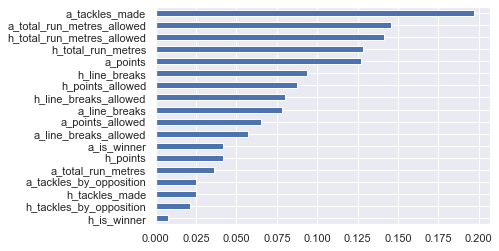

In [33]:
data = predictions_data['4']
data = data.replace([np.inf, -np.inf], 0)
X = data.drop(columns=['home_winner', 'match_id', 'round', 'date'])
X_scaled = StandardScaler().fit_transform(X)
y = data['home_winner']
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

coefficients = log_reg.coef_
feature_importance = pd.Series(coefficients[0], index=X.columns)
ordered_feature_importance = feature_importance.abs().sort_values()
ordered_feature_importance.plot.barh()
plt.show()

In [65]:
data = predictions_data['4']
data = data.replace([np.inf, -np.inf], 0)
feature_index = 0
for feature in list(ordered_feature_importance.sort_values(ascending=False).index):
    feature_index += 1
    features = list(ordered_feature_importance.sort_values(ascending=False).index)[:feature_index]
    X = data.drop(columns=['home_winner', 'match_id', 'round', 'date'])
    X = data[features]
    X_scaled = StandardScaler().fit_transform(X)
    y = data['home_winner']
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=13)
    
    log_reg = LogisticRegression()
    log_reg.fit(X_train, y_train)
    y_pred = log_reg.predict(X_test)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print('Top ' + str(feature_index) + ' features: ' + str(np.round((accuracy_score(y_test, y_pred)), 4)) + ' - AUC: ' + str(np.round(roc_auc, 4)))
    

Top 1 features: 0.5745 - AUC: 0.5
Top 2 features: 0.5673 - AUC: 0.5158
Top 3 features: 0.5964 - AUC: 0.5578
Top 4 features: 0.5927 - AUC: 0.5635
Top 5 features: 0.5818 - AUC: 0.554
Top 6 features: 0.5855 - AUC: 0.5605
Top 7 features: 0.6036 - AUC: 0.5774
Top 8 features: 0.5855 - AUC: 0.5572
Top 9 features: 0.6291 - AUC: 0.6051
Top 10 features: 0.5927 - AUC: 0.5713
Top 11 features: 0.5927 - AUC: 0.5713
Top 12 features: 0.5855 - AUC: 0.5649
Top 13 features: 0.5891 - AUC: 0.567
Top 14 features: 0.5891 - AUC: 0.567
Top 15 features: 0.5891 - AUC: 0.567
Top 16 features: 0.5818 - AUC: 0.5607
Top 17 features: 0.5891 - AUC: 0.5681
Top 18 features: 0.5855 - AUC: 0.5649


In [45]:
list(ordered_feature_importance.sort_values(ascending=False).index)[:2]

['a_tackles_made', 'a_total_run_metres_allowed']

## Random Forest

In [85]:
from sklearn.ensemble import RandomForestClassifier

n_estimators = list(range(1, 300, 20))
random_forest_results = pd.DataFrame({'estimators': n_estimators})
random_state = 0
#for key in predictionos_data:
for key in ['4']:
    data = predictions_data[key]
    data = data.replace([np.inf, -np.inf], 0)

    
    X = data.drop(columns=['home_winner', 'match_id', 'round', 'date'])
    X = X[list(ordered_feature_importance.sort_values(ascending=False).index)[:4]]
    y = data['home_winner']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
    #key_results = []
    accuracy_scores = []
    auc_scores = []
    for i in n_estimators:
        #random_state += 1
        forest = RandomForestClassifier(n_estimators = i, random_state=42)
        forest.fit(X_train, y_train)
        forest_pred = forest.predict(X_test)
        
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, forest_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        auc_scores.append(roc_auc)
        
        score = np.round(accuracy_score(y_test, forest_pred), 4)
        accuracy_scores.append(score)
        #print('Previous ' + key + ' matches - ' + str(i) + ' estimators accuracy: ' + str(np.round(score, 4)))
    #random_forest_results[key] = key_results

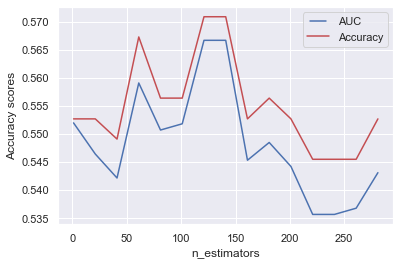

In [86]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, auc_scores, 'b', label="AUC")
line2, = plt.plot(n_estimators, accuracy_scores, 'r', label="Accuracy")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('Accuracy scores')
plt.xlabel('n_estimators')
plt.show()

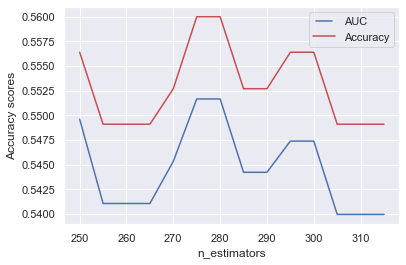

In [87]:
n_estimators = list(range(250, 320, 5))
random_forest_results = pd.DataFrame({'estimators': n_estimators})
random_state = 0
#for key in predictionos_data:
for key in ['4']:
    data = predictions_data[key]
    data = data.replace([np.inf, -np.inf], 0)

    
    X = data.drop(columns=['home_winner', 'match_id', 'round', 'date'])
    X = X[list(ordered_feature_importance.sort_values(ascending=False).index)[:4]]
    y = data['home_winner']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
    #key_results = []
    accuracy_scores = []
    auc_scores = []
    for i in n_estimators:
        #random_state += 1
        forest = RandomForestClassifier(n_estimators = i, random_state=42)
        forest.fit(X_train, y_train)
        forest_pred = forest.predict(X_test)
        
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, forest_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        auc_scores.append(roc_auc)
        
        score = np.round(accuracy_score(y_test, forest_pred), 4)
        accuracy_scores.append(score)
        #print('Previous ' + key + ' matches - ' + str(i) + ' estimators accuracy: ' + str(np.round(score, 4)))
    #random_forest_results[key] = key_results
line1, = plt.plot(n_estimators, auc_scores, 'b', label="AUC")
line2, = plt.plot(n_estimators, accuracy_scores, 'r', label="Accuracy")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('Accuracy scores')
plt.xlabel('n_estimators')
plt.show()

In [88]:
max_depths = np.linspace(1, 30, 32, endpoint=True)
random_forest_results = pd.DataFrame({'estimators': max_depths})
random_state = 0
#for key in predictionos_data:
for key in ['4']:
    data = predictions_data[key]
    data = data.replace([np.inf, -np.inf], 0)

    
    X = data.drop(columns=['home_winner', 'match_id', 'round', 'date'])
    y = data['home_winner']
    #key_results = []
    train_results = []
    test_results = []
    for i in max_depths:
        #random_state += 1
        forest = RandomForestClassifier(max_depth = i, random_state=42)
        forest.fit(X_train, y_train)
        train_pred = forest.predict(X_train)
        
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
        
        y_pred = forest.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)

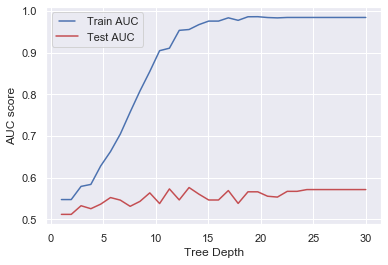

In [89]:
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('AUC score')
plt.xlabel('Tree Depth')
plt.show()

[0.5418]
[0.5418, 0.5309]
[0.5418, 0.5309, 0.5636]
[0.5418, 0.5309, 0.5636, 0.5709]
[0.5418, 0.5309, 0.5636, 0.5709, 0.5527]
[0.5418, 0.5309, 0.5636, 0.5709, 0.5527, 0.5636]
[0.5418, 0.5309, 0.5636, 0.5709, 0.5527, 0.5636, 0.5927]
[0.5418, 0.5309, 0.5636, 0.5709, 0.5527, 0.5636, 0.5927, 0.5818]
[0.5418, 0.5309, 0.5636, 0.5709, 0.5527, 0.5636, 0.5927, 0.5818, 0.5855]
[0.5418, 0.5309, 0.5636, 0.5709, 0.5527, 0.5636, 0.5927, 0.5818, 0.5855, 0.5527]


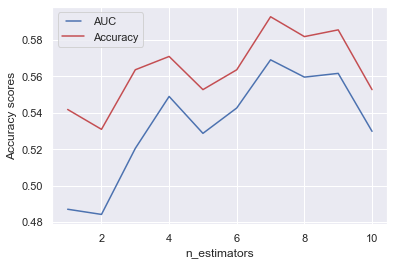

In [91]:
## max_depth = 5
## n_estimators = 295

data = predictions_data['4']
data = data.replace([np.inf, -np.inf], 0)

accuracy_scores = []
auc_scores = []
best_features = list(range(1, 11))
for i in best_features:
    X = data.drop(columns=['home_winner', 'match_id', 'round', 'date'])
    X = X[list(ordered_feature_importance.sort_values(ascending=False).index)[:i]]
    y = data['home_winner']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
    
    forest = RandomForestClassifier(n_estimators = 120, max_depth = 5, random_state=42)
    forest.fit(X_train, y_train)
    forest_pred = forest.predict(X_test)
        
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, forest_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    auc_scores.append(roc_auc)
        
    score = np.round(accuracy_score(y_test, forest_pred), 4)
    accuracy_scores.append(score)
    print(accuracy_scores)
    
line1, = plt.plot(best_features, auc_scores, 'b', label="AUC")
line2, = plt.plot(best_features, accuracy_scores, 'r', label="Accuracy")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('Accuracy scores')
plt.xlabel('n_estimators')
plt.show()

## Gradient Boosting Tree

In [175]:
from sklearn.ensemble import GradientBoostingClassifier
n_estimators = list(range(1, 300, 20))
gradient_results = pd.DataFrame({'estimators': n_estimators})
for key in ['4']:
#for key in predictions_data:
    data = predictions_data[key]
    data = data.replace([np.inf, -np.inf, np.nan], 0)
    X = data.drop(columns=['home_winner', 'match_id', 'round', 'date'])
    y = data['home_winner']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    key_results = []
    for i in n_estimators:
        gradient = GradientBoostingClassifier(n_estimators = i, random_state=42)
        gradient.fit(X_train, y_train)
        gradient_pred = gradient.predict(X_test)
        score = np.round(accuracy_score(y_test, gradient_pred), 4)
        key_results.append(score)
        print('Previous ' + key + ' matches - ' + str(i) + ' estimators accuracy: ' + str(np.round(score, 4)))
    #gradient_results[key] = key_results
#gradient_results = gradient_results.set_index('estimators')
#gradient_results

Previous 4 matches - 1 estimators accuracy: 0.5782
Previous 4 matches - 21 estimators accuracy: 0.5527
Previous 4 matches - 41 estimators accuracy: 0.56
Previous 4 matches - 61 estimators accuracy: 0.5527
Previous 4 matches - 81 estimators accuracy: 0.5527
Previous 4 matches - 101 estimators accuracy: 0.5382
Previous 4 matches - 121 estimators accuracy: 0.5564
Previous 4 matches - 141 estimators accuracy: 0.5745
Previous 4 matches - 161 estimators accuracy: 0.5673
Previous 4 matches - 181 estimators accuracy: 0.56
Previous 4 matches - 201 estimators accuracy: 0.5491
Previous 4 matches - 221 estimators accuracy: 0.5455
Previous 4 matches - 241 estimators accuracy: 0.5273
Previous 4 matches - 261 estimators accuracy: 0.5418
Previous 4 matches - 281 estimators accuracy: 0.5455


## Updating Historical Data...how many games back do we go?

In [88]:
#Piror 8 or 9 matches
#226 - 276 n_estimators
from sklearn.ensemble import RandomForestClassifier
random_forest_results = pd.DataFrame({'estimators': list(range(226, 275))})
random_state = 0
for key in ['8', '9']:
    data = predictions_data[key]
    data = data.replace([np.inf, -np.inf, np.nan], 0)
    X = data.drop(columns=['home_winner', 'match_id', 'round'])
    y = data['home_winner']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    key_results = []
    random_state = 0
    for i in range(226, 275):
        random_state += 1
        forest = RandomForestClassifier(n_estimators = i, random_state=random_state)
        forest.fit(X_train, y_train)
        forest_pred = forest.predict(X_test)
        score = np.round(accuracy_score(y_test, forest_pred), 4)
        key_results.append(score)
        #print('Previous ' + key + ' matches - ' + str(i) + ' estimators accuracy: ' + str(np.round(score, 4)))
    random_forest_results[key] = key_results

In [89]:
random_forest_results

,estimators,8,9
0,226,0.5688,0.5955
1,227,0.5948,0.5805
2,228,0.5539,0.5955
3,229,0.5836,0.5918
4,230,0.5651,0.6067
5,231,0.5762,0.5955
6,232,0.5465,0.5918
7,233,0.5874,0.5918
8,234,0.5725,0.5805
9,235,0.5836,0.5693


## Adding in betting data

## Adding lineup changes as a feature + dropping other features

In [44]:
query = pd.read_sql_query('''
    SELECT * 
    FROM PlayerMatchStats
''', mydb)
player_stat_df = pd.DataFrame(query)
player_stat_df.head()

for match in Matches.all_matches:
    match_id = Matches.all_matches[match].id
    home_id = Matches.all_matches[match].home.id
    home_df = player_stat_df[(player_stat_df['match_id'] == match_id) & (player_stat_df['team_id'] == home_id)]
    home_roster = list(home_df['player_id'])
    
    away_id = Matches.all_matches[match].away.id
    away_df = player_stat_df[(player_stat_df['match_id'] == match_id) & (player_stat_df['team_id'] == away_id)]
    away_roster = list(away_df['player_id'])
#match_stat_df = player_stat_df.groupby(['match_id','team_id']).sum().reset_index()
#match_stat_df = match_stat_df.drop(columns=['id', 'player_id', 'position_id', 'minutes_played'])

,id,match_id,player_id,team_id,position_id,minutes_played,points,tries,conversions,conversion_attempts,...,kicked_dead,errors,handling_errors,one_on_ones_lost,penalties,on_report,sin_bins,send_offs,stint_one,stint_two
0,1,1,385,14,1,80.0,0,0,0,0,...,0,0,0,0,1,0,0,0,80.0,None
1,2,1,481,14,2,80.0,0,0,0,0,...,0,1,1,0,0,0,0,0,80.0,None
2,3,1,378,14,3,80.0,4,1,0,0,...,0,0,0,0,0,0,0,0,80.0,None
3,4,1,388,14,3,80.0,0,0,0,0,...,0,3,2,0,0,0,0,0,80.0,None
4,5,1,482,14,2,80.0,4,1,0,0,...,0,1,1,0,0,0,0,0,80.0,None


In [65]:
for match in Matches.all_matches:
    match_id = Matches.all_matches[match].id
    home_id = Matches.all_matches[match].home.id
    home_df = player_stat_df[(player_stat_df['match_id'] == match_id) & (player_stat_df['team_id'] == home_id)]
    home_roster = list(home_df['player_id'])
    
    away_id = Matches.all_matches[match].away.id
    away_df = player_stat_df[(player_stat_df['match_id'] == match_id) & (player_stat_df['team_id'] == away_id)]
    away_roster = list(away_df['player_id'])
    

[385, 481, 378, 388, 482, 379, 376, 396, 391, 404, 407, 406, 483, 402, 484, 1626, 397]
[209, 212, 200, 213, 211, 208, 210, 192, 201, 503, 196, 188, 197, 504, 505, 194, 190]
[244, 254, 252, 250, 517, 258, 519, 272, 265, 268, 264, 520, 266, 260, 276, 267, 261]
[521, 458, 461, 522, 523, 457, 464, 453, 524, 448, 441, 452, 443, 440, 439, 449, 525]
[346, 527, 351, 352, 528, 349, 345, 369, 361, 366, 364, 529, 367, 360, 363, 368, 530]
[490, 491, 492, 84, 82, 493, 80, 494, 68, 495, 67, 70, 64, 61, 62, 538, 66]
[319, 323, 326, 543, 316, 320, 324, 330, 544, 332, 329, 545, 546, 335, 342, 547, 336]
[117, 112, 115, 554, 118, 555, 113, 127, 556, 132, 131, 557, 126, 134, 133, 558, 1639]
[91, 97, 87, 471, 472, 94, 89, 103, 473, 474, 475, 476, 477, 478, 479, 104, 480]
[432, 431, 486, 433, 487, 435, 430, 414, 413, 421, 409, 488, 412, 489, 424, 423, 417]
[22, 20, 27, 497, 26, 19, 498, 11, 3, 500, 2, 10, 501, 499, 9, 502, 566]
[531, 238, 532, 533, 241, 236, 534, 535, 225, 220, 224, 234, 231, 536, 230, 537,

[432, 431, 486, 433, 487, 435, 430, 414, 413, 421, 409, 412, 423, 488, 424, 417, 416]
[84, 491, 492, 79, 83, 81, 493, 62, 68, 64, 67, 72, 61, 77, 538, 69, 63]
[209, 591, 200, 622, 212, 1638, 210, 195, 191, 190, 196, 197, 188, 192, 194, 505, 628]
[346, 348, 530, 351, 344, 349, 345, 369, 361, 363, 364, 529, 367, 360, 588, 368, 347]
[385, 383, 378, 388, 482, 379, 376, 396, 391, 404, 407, 406, 483, 397, 484, 1626, 402]
[280, 279, 285, 548, 281, 550, 286, 614, 304, 306, 299, 305, 300, 283, 296, 302, 293]
[432, 431, 486, 433, 487, 488, 430, 414, 413, 421, 409, 412, 423, 489, 424, 417, 627]
[472, 91, 576, 471, 96, 94, 89, 103, 473, 474, 582, 476, 477, 605, 479, 102, 475]
[543, 323, 326, 318, 316, 320, 324, 332, 338, 330, 342, 545, 329, 325, 546, 547, 335]
[258, 254, 248, 620, 252, 249, 519, 272, 265, 268, 264, 260, 266, 244, 267, 261, 276]
[531, 238, 239, 533, 241, 236, 534, 535, 225, 221, 224, 220, 590, 227, 230, 222, 532]
[346, 347, 530, 351, 527, 349, 345, 369, 361, 363, 364, 529, 367, 360

[208, 218, 219, 215, 212, 216, 205, 191, 193, 196, 200, 194, 192, 195, 198, 188, 217]
[94, 97, 88, 92, 91, 95, 89, 102, 473, 474, 108, 478, 477, 93, 475, 616, 107]
[319, 323, 318, 1647, 314, 321, 320, 330, 1644, 329, 342, 545, 580, 327, 332, 335, 322]
[208, 218, 219, 215, 212, 216, 210, 205, 191, 195, 194, 200, 192, 213, 206, 190, 203]
[344, 351, 1646, 347, 348, 349, 345, 368, 361, 373, 364, 360, 362, 365, 1656, 374, 370]
[19, 28, 1652, 1653, 22, 6, 11, 3, 14, 2, 500, 18, 7, 9, 4, 12, 26]
[178, 185, 187, 179, 175, 174, 164, 159, 169, 162, 168, 161, 158, 160, 165, 182, 180]
[433, 431, 486, 428, 437, 435, 430, 414, 413, 421, 418, 417, 423, 412, 408, 422, 419]
[458, 468, 466, 461, 459, 457, 464, 569, 451, 439, 454, 441, 448, 445, 456, 443, 449]
[385, 382, 378, 388, 386, 1630, 397, 391, 390, 395, 406, 402, 400, 405, 376, 404, 407]
[19, 20, 28, 26, 22, 6, 11, 3, 14, 2, 500, 18, 7, 9, 4, 12, 1654]
[319, 323, 318, 1647, 314, 320, 324, 330, 1644, 329, 342, 327, 545, 580, 321, 332, 335]
[531, 5

[568, 185, 187, 589, 179, 539, 1806, 541, 159, 169, 162, 168, 161, 165, 2131, 160, 1994]
[491, 79, 492, 2058, 82, 1757, 490, 62, 68, 1970, 67, 61, 538, 1969, 64, 70, 493]
[2108, 591, 1858, 2101, 211, 504, 2102, 190, 191, 2103, 200, 2126, 197, 2104, 199, 603, 193]
[22, 20, 27, 2054, 497, 19, 498, 2056, 3, 2055, 2, 10, 501, 502, 499, 500, 2364]
[151, 145, 143, 507, 508, 2092, 142, 1713, 153, 509, 515, 155, 512, 513, 570, 2140, 571]
[40, 45, 41, 43, 42, 560, 33, 564, 55, 2078, 56, 563, 54, 2079, 58, 50, 565]
[482, 481, 378, 388, 484, 379, 2067, 2068, 391, 404, 407, 2069, 483, 406, 1642, 578, 2361]
[1966, 326, 318, 543, 316, 2071, 324, 330, 544, 335, 545, 329, 546, 2073, 332, 2074, 2070]
[280, 2030, 285, 549, 284, 293, 550, 553, 297, 306, 298, 305, 300, 552, 302, 294, 614]
[40, 45, 41, 43, 42, 560, 33, 564, 55, 2078, 56, 563, 54, 2079, 58, 565, 50]
[346, 530, 528, 2059, 1901, 364, 349, 369, 361, 363, 365, 529, 367, 621, 588, 2061, 360]
[280, 2030, 285, 549, 284, 293, 550, 553, 297, 306, 29

[151, 506, 143, 507, 508, 2092, 142, 2140, 153, 510, 515, 155, 512, 513, 571, 1713, 509]
[568, 185, 187, 177, 179, 175, 1806, 164, 159, 1994, 162, 1808, 168, 169, 1813, 2393, 2381]
[211, 591, 1858, 2101, 212, 2391, 2102, 193, 191, 195, 196, 194, 197, 2126, 2394, 199, 2383]
[385, 481, 1990, 388, 482, 379, 484, 406, 391, 404, 407, 2069, 483, 1642, 578, 390, 2067]
[1920, 459, 461, 522, 523, 521, 464, 1886, 2065, 610, 2115, 569, 448, 439, 599, 2392, 2395]
[2089, 486, 488, 417, 487, 435, 1677, 414, 413, 489, 409, 1679, 412, 2090, 421, 2091, 431]
[568, 185, 187, 177, 179, 175, 1806, 164, 159, 1994, 162, 1808, 161, 168, 169, 541, 1813]
[151, 506, 143, 507, 508, 2092, 142, 2140, 153, 510, 515, 155, 512, 513, 571, 1713, 509]
[472, 97, 2051, 471, 2050, 2052, 89, 103, 473, 474, 582, 476, 477, 475, 1836, 2114, 479]
[498, 20, 27, 2054, 497, 19, 2117, 499, 1704, 2055, 2, 10, 501, 2364, 2057, 9, 2056]
[287, 2030, 285, 293, 549, 550, 286, 294, 551, 306, 298, 575, 300, 552, 553, 297, 302]
[568, 185, 18

KeyboardInterrupt: 

In [137]:
results_df.head()
prediction_percent = len(results_df[results_df['correct_prediction'] == True]) / results_df.shape[0]
betting_percent = len(results_df[results_df['correct_odds'] == True]) / results_df.shape[0]                                   
print('prediction_percentage = ' + str(prediction_percent))
print('betting_percentage = ' + str(betting_percent))

prediction_percentage = 0.58
betting_percentage = 0.62


In [73]:
mycursor.close()

True